In [9]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tif
import glob
from scipy.signal import convolve2d
import cv2
%matplotlib inline

In [20]:
#!pip install opencv-python

  Using cached opencv_python-4.4.0.46-cp38-cp38-manylinux2014_x86_64.whl (49.5 MB)
You should consider upgrading via the '/home/hasitha/Desktop/spam/spam/bin/python3 -m pip install --upgrade pip' command.


In [1]:
filepath = '/home/hasitha/Desktop/data/tescan_high/'
filename = 'recon_zoom_'

In [2]:
def image_normalization(img, L):
    """
    img: np.ndarray:
    L  : power of 2
    """
    _min, _max = img.min(), img.max()
    img = ((img-_min)/(_max-_min)*(L-1)).astype(np.uint8)
    return img

In [3]:
def image_histogram(img, L, disp=False):
    img = image_normalization(img, L)
    out = np.zeros(L)
    for i in np.arange(L):
        out[i] = np.sum(img==i)
    if disp:
        plt.figure(figsize=(6,6))
        plt.bar(np.arange(L), out)
        plt.title('image histogram, L = {}'.format(L))
        plt.show()
    return out

In [4]:
# this does not give better result, do not use it
def histogram_equalization(img, L, disp=False):
    img = image_normalization(img, L)
    hist = image_histogram(img, L)
    mapping = np.zeros(L)
    for i in np.arange(L):
        mapping[i] = int((L-1)*np.sum(hist[:i+1]))
    mapper = np.vectorize(lambda x: mapping[x])
    out = mapper(img)
    out = image_normalization(out, L)
    
    if disp:
        plt.figure(figsize=(8,8))
        plt.imshow(out, plt.cm.gray)
        plt.title('image after equalization')
        plt.show()
    return out

In [5]:
def gaussian_kernel(size, sigma=None):
    assert size%2 == 1 and size > 0, 'size must be odd positive integer' 
    if sigma == None:
        sigma = size // 6
    center = size//2
    kernel = np.zeros((size, size))
    for i in np.arange(size):
        for j in np.arange(size):
            diff2 = (i-center)**2 + (j-center)**2
            kernel[i,j] = np.exp(-diff2/sigma**2/2)
    out = kernel/np.sum(kernel)
    return out

In [6]:
def unsharp_mask(imgs, size, sigma, K, N):
    if len(imgs.shape) == 2:
        m, n = imgs.shape
        imgs = imgs.reshape(1, m, n)
    l = imgs.shape[0]
    sharpened = np.zeros(imgs.shape)
    for i in np.arange(l):
        img = imgs[i,:,:]
        img    = image_normalization(img, 256)
        kernel = gaussian_kernel(size, sigma)
        blur   = convolve2d(img, kernel, mode='same', boundary='symm')
        mask   = img - blur
        mask   = image_normalization(mask, K)
        out    = img + N*mask
        sharpened[i,:,:] = image_normalization(out, 256)
    return sharpened

In [7]:
def image_binary(imgs):
    if len(imgs.shape) == 2:
        m, n = imgs.shape
        imgs = imgs.reshape(1, m, n)
    l = imgs.shape[0]
    binaries = np.zeros(imgs.shape)
    for i in np.arange(l):
        img = imgs[i,:,:]
        img = image_normalization(img, 256)
        hist = image_histogram(img,256,True)
        sorted_hist = np.argsort(hist)
        print(sorted_hist[::-1][:5])
        hist[hist==0] = np.inf
        clf = np.argmin(hist[70:100])+70
        print("the {}-th image, has min {}".format(i,clf))
        binary = img > clf
        binaries[i,:,:] = binary
    return binaries

In [23]:
"""
layers = 100

mask = np.zeros((400,400))
for i in np.arange(400):
    for j in np.arange(400):
        mask[i,j] = -1e10 if (i-200)**2 + (j-200)**2 > 200**2 else 0
        
full_img = np.zeros((layers, 400, 400))
for i in np.arange(layers):
    file = filepath + filename + '{:05d}'.format(i+200)+'.tif'
    img  = tif.imread(file)
    #print(img.shape)
    full_img[i] = img[550:950,550:950] + mask

full_img[full_img < 0] = 0

for i in np.arange(layers):
    full_img[i] = image_normalization(full_img[i], 256)
"""

"\nlayers = 100\n\nmask = np.zeros((400,400))\nfor i in np.arange(400):\n    for j in np.arange(400):\n        mask[i,j] = -1e10 if (i-200)**2 + (j-200)**2 > 200**2 else 0\n        \nfull_img = np.zeros((layers, 400, 400))\nfor i in np.arange(layers):\n    file = filepath + filename + '{:05d}'.format(i+200)+'.tif'\n    img  = tif.imread(file)\n    #print(img.shape)\n    full_img[i] = img[550:950,550:950] + mask\n\nfull_img[full_img < 0] = 0\n\nfor i in np.arange(layers):\n    full_img[i] = image_normalization(full_img[i], 256)\n"

In [8]:
layers = 400
imgs = []
full_img = np.zeros((layers,400,400))
for i in np.arange(layers):
    file = filepath + filename + '{:05d}'.format(i+600)+'.tif'
    img = tif.imread(file)
    full_img[i] = img[550:950,550:950]
    imgs += [img]
    
for i in np.arange(layers):
    full_img[i] = image_normalization(full_img[i],256)

NameError: name 'np' is not defined

In [19]:
len(imgs)

400

In [20]:
m,n = imgs[0].shape
images = np.zeros((400,m,n))
for i in np.arange(400):
    images[i] = imgs[i]

In [21]:
images.shape

(400, 1500, 1500)

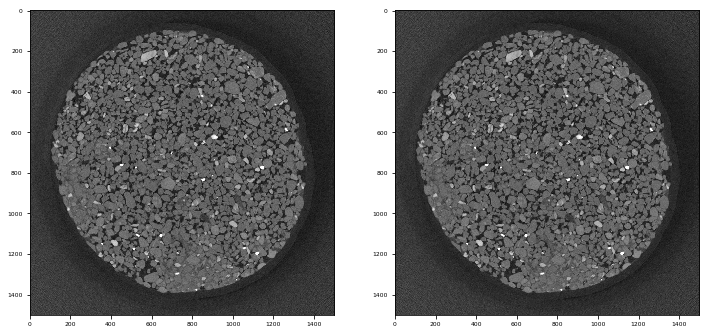

In [26]:
plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.imshow(sample_img, plt.cm.gray)
plt.subplot(1,2,2)
plt.imshow(sample_nlm, plt.cm.gray)

In [31]:
sample_img = images[0]
sample_img = image_normalization(sample_img, 256)

In [32]:
sigma_est = np.mean(estimate_sigma(sample_img, multichannel=False))
sample_nlm = denoise_nl_means(sample_img, h=1.15 * sigma_est, fast_mode=False, patch_size=5, patch_distance=6, multichannel=False)

In [36]:
sample_nlm = sample_nlm.astype(np.uint8)

In [38]:
sample_nlm.min()

0

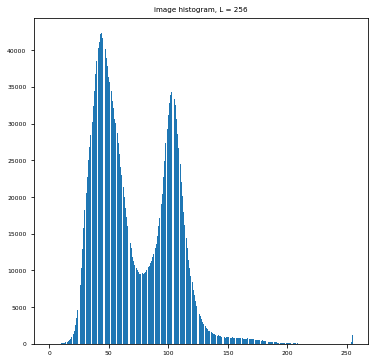

In [47]:
hist = image_histogram(sample_nlm, 256, True)

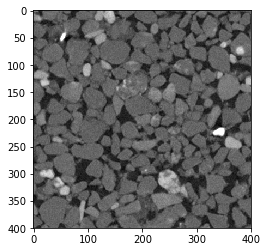

In [10]:
plt.imshow(full_img[34], plt.cm.gray)

In [11]:
import spam.label
from skimage.restoration import denoise_nl_means, estimate_sigma

In [12]:
nlm_img = np.zeros(full_img.shape)
for idx in np.arange(layers):
    print('processing {}-th image'.format(idx))
    sigma_est = np.mean(estimate_sigma(full_img[idx], multichannel=False))
    nlm_img[idx] = denoise_nl_means(full_img[idx], h=1.15 * sigma_est, fast_mode=False, patch_size=5, patch_distance=6, multichannel=False)

processing 0-th image
processing 1-th image
processing 2-th image
processing 3-th image
processing 4-th image
processing 5-th image
processing 6-th image
processing 7-th image
processing 8-th image
processing 9-th image
processing 10-th image
processing 11-th image
processing 12-th image
processing 13-th image
processing 14-th image
processing 15-th image
processing 16-th image
processing 17-th image
processing 18-th image
processing 19-th image
processing 20-th image
processing 21-th image
processing 22-th image
processing 23-th image
processing 24-th image
processing 25-th image
processing 26-th image
processing 27-th image
processing 28-th image
processing 29-th image
processing 30-th image
processing 31-th image
processing 32-th image
processing 33-th image
processing 34-th image
processing 35-th image
processing 36-th image
processing 37-th image
processing 38-th image
processing 39-th image
processing 40-th image
processing 41-th image
processing 42-th image
processing 43-th imag

processing 346-th image
processing 347-th image
processing 348-th image
processing 349-th image
processing 350-th image
processing 351-th image
processing 352-th image
processing 353-th image
processing 354-th image
processing 355-th image
processing 356-th image
processing 357-th image
processing 358-th image
processing 359-th image
processing 360-th image
processing 361-th image
processing 362-th image
processing 363-th image
processing 364-th image
processing 365-th image
processing 366-th image
processing 367-th image
processing 368-th image
processing 369-th image
processing 370-th image
processing 371-th image
processing 372-th image
processing 373-th image
processing 374-th image
processing 375-th image
processing 376-th image
processing 377-th image
processing 378-th image
processing 379-th image
processing 380-th image
processing 381-th image
processing 382-th image
processing 383-th image
processing 384-th image
processing 385-th image
processing 386-th image
processing 387-t

In [13]:
save_path = '/home/hasitha/Desktop/packed_img/'
tif.imsave(save_path+'NLM_400.tif', nlm_img)

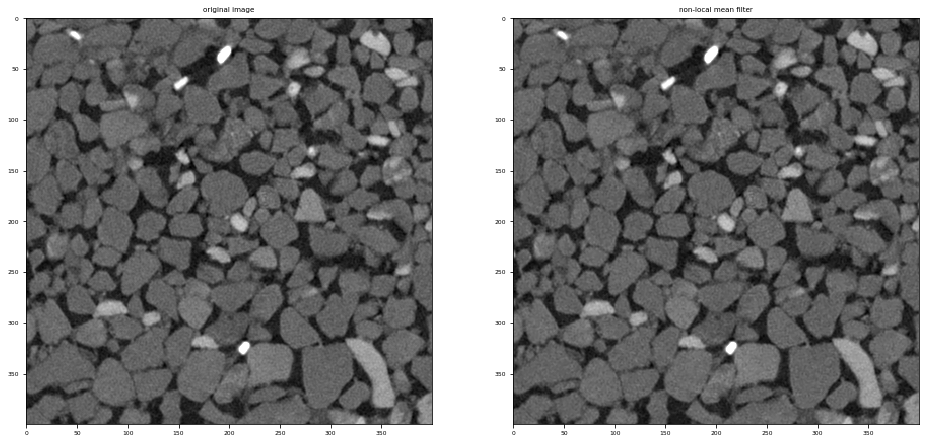

In [76]:
idx = 67
plt.figure(figsize=(16,16))
plt.subplot(1,2,1)
plt.imshow(full_img[idx], plt.cm.gray)
plt.title('original image')
plt.subplot(1,2,2)
plt.imshow(nlm_img[idx], plt.cm.gray)
plt.title('non-local mean filter')
plt.show()

In [115]:
def gaussian_pdf (X, mu, sigma, w):
    # Gaussian probability density function
    return np.linalg.det(sigma)**(-0.5)*(2*np.pi)**(-X.shape[1]/2.)*np.exp(-0.5*np.einsum('i,ij,ji->i',w,X-mu,np.linalg.inv(sigma)@(X-mu).T))
"""
def gaussian_pdf (X, mu, sigma):
    # Gaussian probability density function
    n, k = X.shape
    return np.array([ np.linalg.det(sigma)**(-0.5)*(2*np.pi)**(-k/2.)*np.exp(-0.5 * (X[i] - mu).T @ np.linalg.inv(sigma) @ (X[i] - mu)) for i in np.arange(n) ])
"""

def EM_initial_guess (num_dims, data, num_samples, num_clusters, scale=16):
    # randomly choose the starting centroids/means
    # as num_clusters of the points from datasets
    idxs = np.random.choice(num_samples, num_clusters, False)
    mu = data[idxs, :]
    # avoid local minimum use prior knowledge
    while (mu.max()-mu.min())*scale < 50 or mu.min()*scale > 50:
        idxs = np.random.choice(num_samples, num_clusters, False)
        mu = data[idxs, :]

    # initialize the covariance matrice for each gaussian
    sigma = [np.eye(num_dims)] * num_clusters

    # initialize the probabilities/weights for each gaussian
    # begin with equal weight for each gaussian
    alpha = [1./num_clusters] * num_clusters

    return mu, sigma, alpha

def EM_E_step (num_clusters, num_samples, data, mu, sigma, alpha, w):
    ## Vectorized implementation of e-step equation to calculate the
    ## membership for each of k-gaussians
    Q = np.zeros((num_samples, num_clusters))
    for k in range(num_clusters):
        Q[:, k] = alpha[k] * gaussian_pdf(data, mu[k], sigma[k], w)
    ## Normalize so that the responsibility matrix is row stochastic
    Q = (Q.T / np.sum(Q, axis = 1)).T
    return Q

def EM_M_step (num_clusters, num_dims, num_samples, Q, data, w):

    # M Step
    ## calculate the new mean and covariance for each gaussian by
    ## utilizing the new responsibilities
    mu      = np.zeros((num_clusters, num_dims))
    sigma   = np.zeros((num_clusters, num_dims, num_dims))
    alpha   = np.zeros(num_clusters)

    ## The number of datapoints belonging to each gaussian
    num_samples_per_cluster = np.sum(Q, axis=0)
    weighted_sum = np.einsum('i,ij->j',w,Q)
    #num_samples_per_cluster = np.einsum('i, ij -> j', w, Q)
    #print(num_samples_per_cluster.shape)

    for k in range(num_clusters):
        ## means
        #print(Q[:,k].shape)
        #print(data.shape)
        mu[k] = 1./weighted_sum[k] * np.sum(w*Q[:,k]*data.T, axis = 1).T
        centered_data = np.matrix(data - mu[k])

        ## covariances
        sigma[k] = np.array(1./num_samples_per_cluster[k]*np.dot(np.multiply(centered_data.T, w*Q[:, k]), centered_data))

        ## and finally the probabilities
        alpha[k] = 1./num_samples * num_samples_per_cluster[k]

    return mu, sigma, alpha

def EM_log_likelihood_calc (num_clusters, num_samples, data, mu, sigma, alpha, w):
    L = np.zeros((num_samples, num_clusters))
    for k in range(num_clusters):
        L[:, k] = alpha[k] * gaussian_pdf(data, mu[k], sigma[k], w)
    return np.sum(np.log(np.sum(L, axis = 1)))


def EM_calc (num_dims, num_samples, num_clusters, x, ALPHA, verbose=False):
    log_likelihoods = []
    labels          = []
    iter_cnt        = 0
    epsilon         = 0.5
    max_iters       = 500
    update          = 2*epsilon
    w               = np.ones(len(x))

    # initial guess
    mu, sigma, alpha = EM_initial_guess(num_dims, x, num_samples, num_clusters)
    mus = [mu]
    sigmas = [sigma]
    alphas = [alpha]
    while (update > epsilon) and (iter_cnt < max_iters):
        iter_cnt += 1

        # E - Step
        Q = EM_E_step (num_clusters, num_samples, x, mu, sigma, alpha, w)

        # M - Step
        mu, sigma, alpha = EM_M_step (num_clusters, num_dims, num_samples, Q, x, w)

        mus.append(mu*16)
        sigmas.append(sigma)
        alphas.append(alpha)

        # Likelihood computation
        likelihood = EM_log_likelihood_calc(num_clusters, num_samples, x, mu, sigma, alpha, w)
        log_likelihoods.append(likelihood)
        print((mu*16).flatten(), likelihood, iter_cnt)

        # check convergence
        if iter_cnt >= 2 :
            update = np.abs(log_likelihoods[-1] - log_likelihoods[-2])
            #update = np.abs(mus[-1].min() - mus[-1].min())

        # logging
        if verbose:
            print("iteration {}, update {}".format(iter_cnt, update))
        
        # print current iteration
        label = np.argmax(Q, axis = 1)
        labels.append(label)
        w = np.ones(len(x))
        w[label == np.argmin(mu)] = ALPHA
    print('require {} steps to finish with alpha {}'.format(iter_cnt, ALPHA))
    return labels[-1], log_likelihoods[-1], {'mu': mus[-1], 'sigma': sigmas[-1], 'alpha': alphas[-1]}


In [41]:
"""
idx = 79
data = nlm_img[idx].reshape(-1,1)
EM_labels, log_likelihoods, EM_parms = EM_calc(num_dims=1,num_samples=len(data),num_clusters=2,x=data/16)
while(EM_parms['mu'].min()>60):
    EM_labels, log_likelihoods, EM_parms = EM_calc(num_dims=1,num_samples=len(data),num_clusters=2,x=data/16)
EM_binary = EM_labels != np.argmin(EM_parms['mu'])
print(EM_parms)
#EM_binary = EM_binary.reshape(100,100)
#print(EM_binary.shape)
"""

"\nidx = 79\ndata = nlm_img[idx].reshape(-1,1)\nEM_labels, log_likelihoods, EM_parms = EM_calc(num_dims=1,num_samples=len(data),num_clusters=2,x=data/16)\nwhile(EM_parms['mu'].min()>60):\n    EM_labels, log_likelihoods, EM_parms = EM_calc(num_dims=1,num_samples=len(data),num_clusters=2,x=data/16)\nEM_binary = EM_labels != np.argmin(EM_parms['mu'])\nprint(EM_parms)\n#EM_binary = EM_binary.reshape(100,100)\n#print(EM_binary.shape)\n"

In [32]:
np.empty((3,3))

array([[-1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])

In [30]:
sample_nlm.max()

65535.00000000002

[ 51.854 108.668] -4520579.790922817 1
[ 50.312 106.503] -4383129.225126972 2
[ 48.798 104.862] -4336320.161227312 3
[ 47.767 103.467] -4312530.77830953 4
[ 47.089 102.277] -4302279.552963009 5
[ 46.624 101.304] -4296571.489965033 6
[ 46.291 100.484] -4294544.244194898 7
[46.044 99.777] -4294825.013672505 8
[45.849 99.188] -4294517.030006254 9
[45.689 98.714] -4292898.000093942 10
[45.564 98.286] -4293893.331403385 11
[45.465 97.903] -4295366.752764002 12
[45.376 97.596] -4294755.085810087 13
[45.3   97.336] -4294313.1985149225 14
[45.243 97.078] -4296401.259162207 15
[45.19  96.874] -4296142.716076428 16
[45.143 96.701] -4295959.129190874 17
[45.102 96.553] -4295819.567934829 18
[45.067 96.426] -4295724.182641887 19
[45.046 96.279] -4298143.2292876905 20
[45.022 96.168] -4298089.544237354 21
[45.    96.075] -4298037.303623514 22
[44.979 95.996] -4297998.468422271 23
[44.961 95.927] -4297988.661703964 24
[44.946 95.868] -4297967.009800493 25
[44.932 95.818] -4297950.857182449 26
[44.92

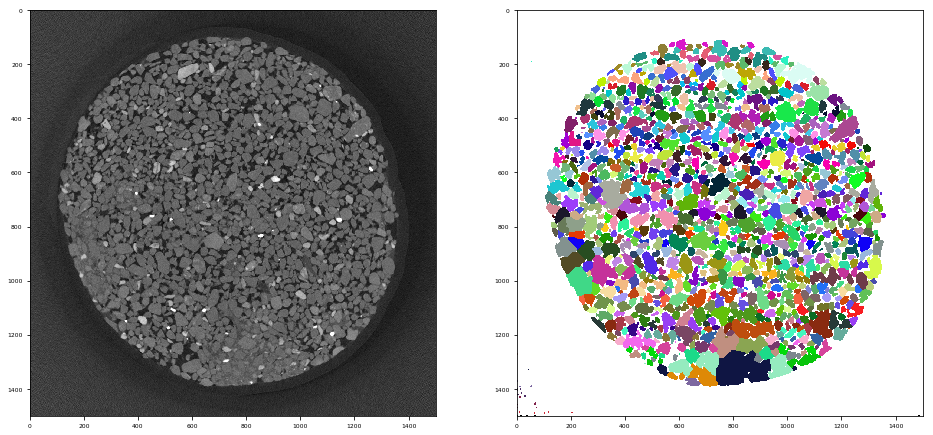

In [130]:
EM_binary = np.empty(sample_nlm.shape)
kernel = np.ones((5,5))
ALPHA = .9
fail_cnts = 0
data = sample_nlm.reshape(-1,1)
EM_labels, log_likelihoods, EM_parms = EM_calc(num_dims=1,num_samples=len(data),num_clusters=2,x=data/16, ALPHA=ALPHA)
while(EM_parms['mu'].min()>60):
    fail_cnts += 1
    if fail_cnts >= 3:
        ALPHA -= (fail_cnts-2)*0.05
        EM_labels, log_likelihoods, EM_parms = EM_calc(num_dims=1,num_samples=len(data),num_clusters=2,x=data/16, ALPHA=ALPHA)
EM_binary = (EM_labels != np.argmin(EM_parms['mu'])).reshape(1500,1500)
EM_binary = cv2.morphologyEx(np.float32(EM_binary), cv2.MORPH_OPEN, kernel,iterations=1).astype(np.bool)
print('{}-th image with mean {}'.format(i, EM_parms['mu'].flatten()))

full_water = spam.label.watershed(EM_binary)
plt.figure(figsize=(16,16))
plt.subplot(1,2,1)
plt.imshow(sample_nlm, plt.cm.gray)
plt.subplot(1,2,2)
plt.imshow(full_water, cmap=spam.label.randomCmap)
plt.show()

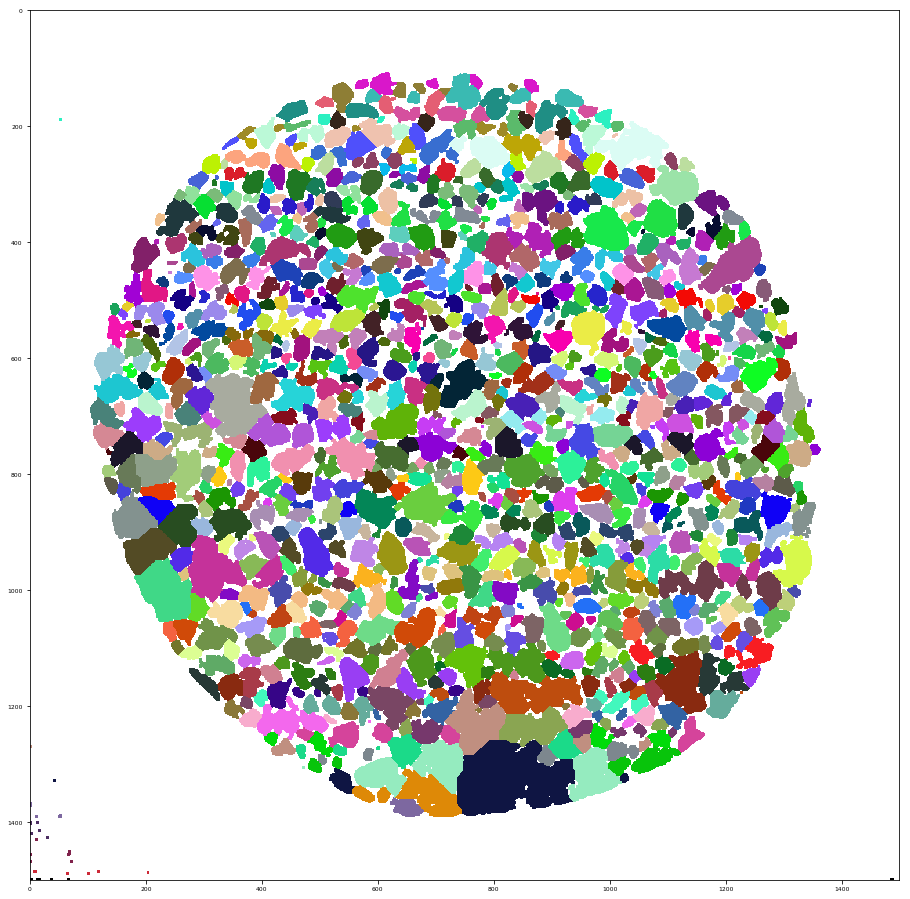

In [131]:
#void weight = 0.25
plt.figure(figsize=(16,16))
plt.imshow(full_water, cmap=spam.label.randomCmap)

In [80]:
full_water.max()

1585

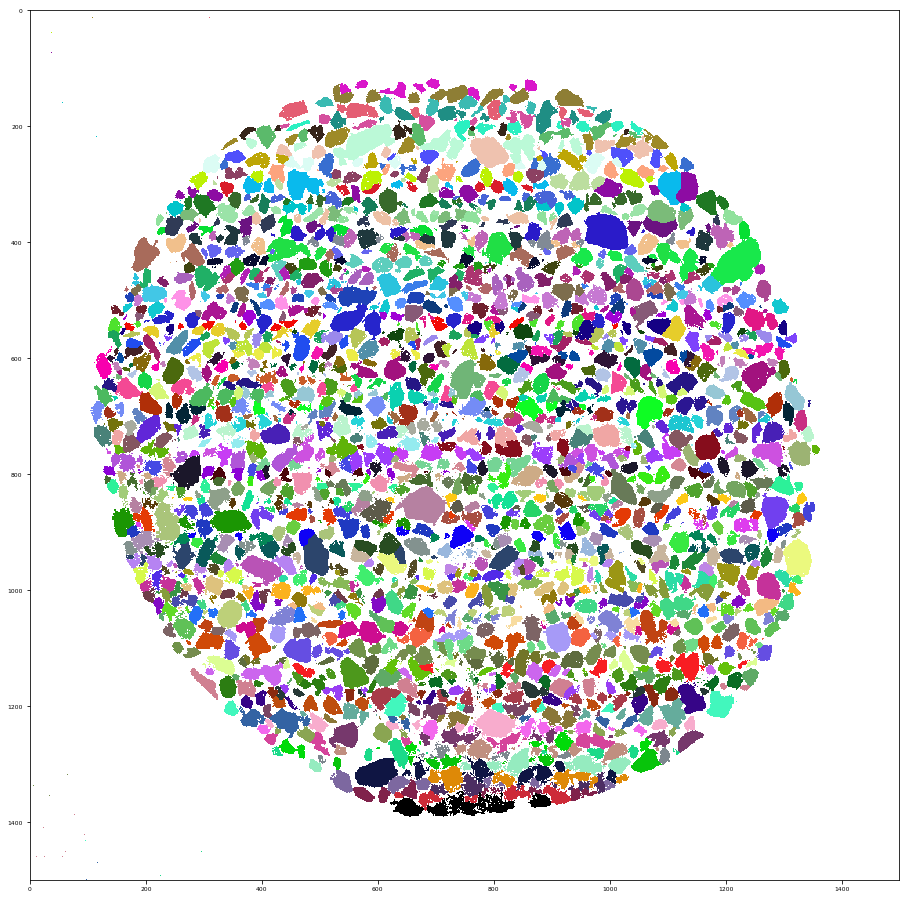

In [91]:
sample_binary = sample_nlm > 90
full_water = spam.label.watershed(sample_binary)
plt.figure(figsize=(16,16))
plt.imshow(full_water, cmap=spam.label.randomCmap)

In [56]:
EM_binaries = np.empty(nlm_img.shape)
kernel = np.ones((3,3))
for i in np.arange(1):
    ALPHA = 1.75
    fail_cnts = 0
    data = nlm_img[i].reshape(-1,1)
    EM_labels, log_likelihoods, EM_parms = EM_calc(num_dims=1,num_samples=len(data),num_clusters=2,x=data/16, ALPHA=ALPHA)
    while(EM_parms['mu'].min()>60):
        fail_cnts += 1
        if fail_cnts >= 3:
            ALPHA -= (fail_cnts-2)*0.1
            EM_labels, log_likelihoods, EM_parms = EM_calc(num_dims=1,num_samples=len(data),num_clusters=2,x=data/16, ALPHA=ALPHA)
    EM_binary = (EM_labels != np.argmin(EM_parms['mu'])).reshape(400,400)
    EM_binary = cv2.morphologyEx(np.float32(EM_binary), cv2.MORPH_OPEN, kernel,iterations=1)
    print('{}-th image with mean {}'.format(i, EM_parms['mu'].flatten()))
    EM_binaries[i] = EM_binary

[6.516 3.219] -323586.4671284212 1
[6.434 3.086] -336515.6316640519 2
[6.42  3.068] -334247.57658074476 3
[6.416 3.056] -333569.58108904917 4
[6.413 3.05 ] -333511.975415319 5
[6.414 3.036] -332958.1777872138 6
[6.412 3.028] -332933.15579373535 7
[6.41 3.02] -332919.36408320715 8
[6.408 3.014] -332909.9047208099 9
[6.406 3.008] -332901.56067796954 10
[6.404 3.003] -332891.13858864544 11
[6.403 2.999] -332871.7731821029 12
[6.401 2.994] -332825.4466835006 13
[6.403 2.983] -332301.5237478572 14
[6.402 2.977] -332277.25830556965 15
[6.4   2.971] -332257.37282346515 16
[6.399 2.966] -332246.0232120738 17
[6.397 2.962] -332239.989535902 18
[6.396 2.959] -332233.7469486501 19
[6.395 2.956] -332227.9119202304 20
[6.394 2.953] -332222.3773805566 21
[6.393 2.951] -332217.8376410019 22
[6.392 2.949] -332213.4649365807 23
[6.391 2.947] -332206.8918797547 24
[6.391 2.945] -332194.97598733765 25
[6.39  2.944] -332182.32658519555 26
[6.39  2.942] -332159.6028355711 27
[6.39  2.941] -332118.956404872

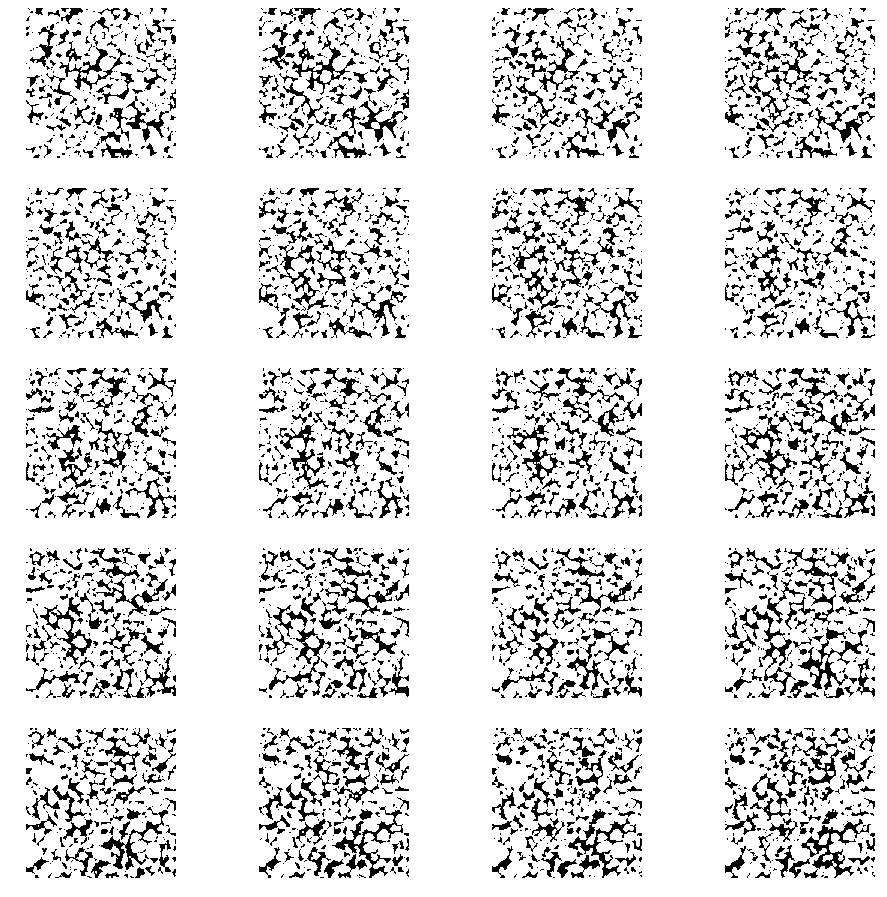

In [90]:
plt.figure(figsize=(16,16))
for i in np.arange(20):
    plt.subplot(5,4,i+1)
    plt.imshow(EM_binaries[80+i], plt.cm.gray)
    plt.axis('off')

In [91]:
EM_water = spam.label.watershed(EM_binaries, verbose=True)

	ITKwatershed.watershed(): Running watershed...done.
	ITKwatershed.watershed(): Collecting labelled image...done.


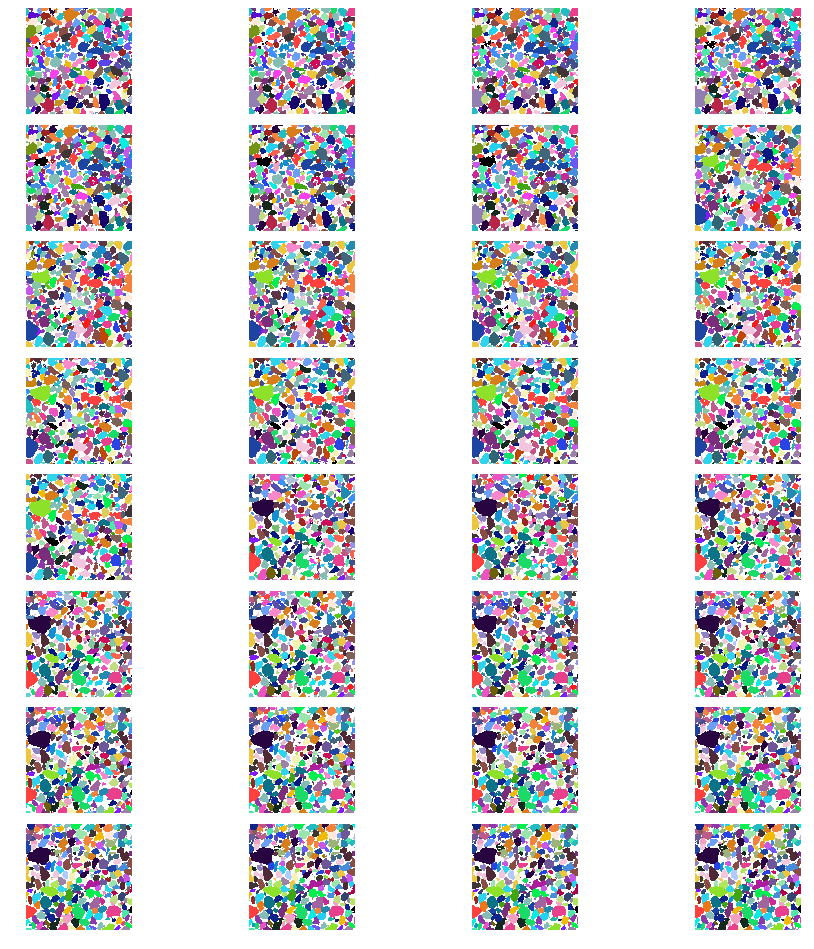

In [122]:
left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.   # the amount of width reserved for blank space between subplots
hspace = 0.1   # the amount of height reserved for white space between subplots

plt.figure(figsize=(16,16))
plt.subplots_adjust(left, bottom, right, top, wspace, hspace)
for i in np.arange(32):
    plt.subplot(8,4,i+1)
    plt.imshow(EM_water[80+i], cmap=spam.label.randomCmap)
    plt.axis('off')

In [93]:
EM_water.max()

3255

In [14]:
clf = 75
global_binaries = nlm_img > clf

In [15]:
G_water = spam.label.watershed(global_binaries, verbose=True)

	ITKwatershed.watershed(): Running watershed...done.
	ITKwatershed.watershed(): Collecting labelled image...done.


In [16]:
G_water.max()
#2715

3491

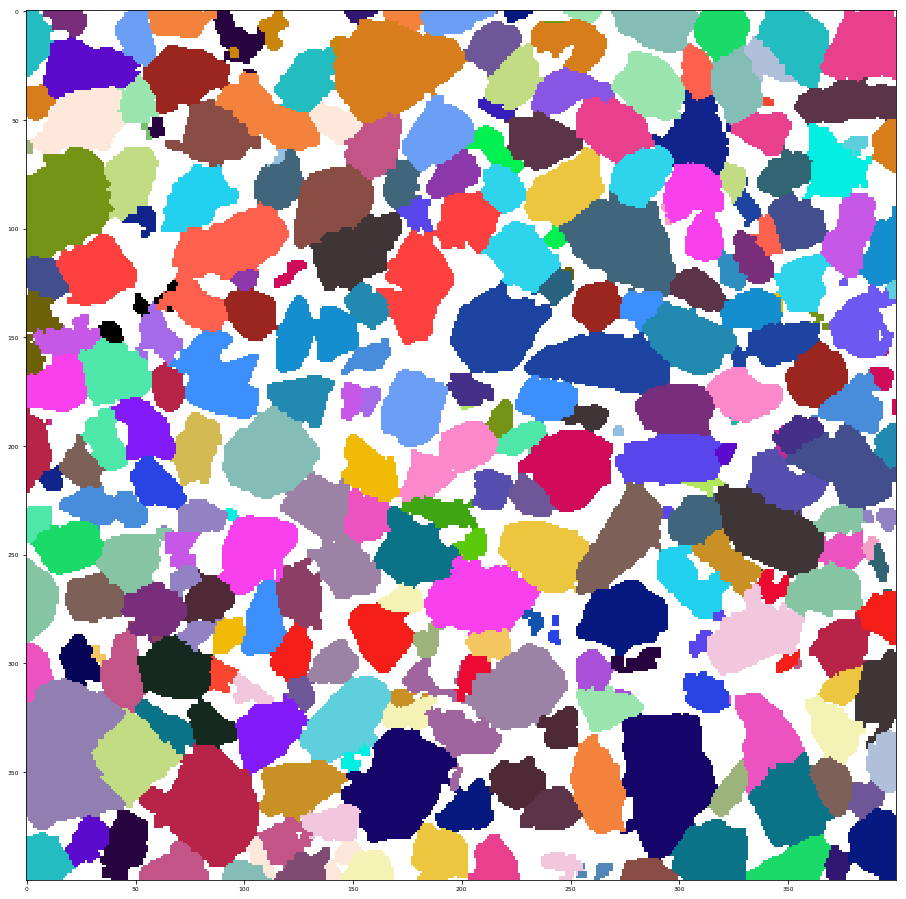

In [125]:
plt.figure(figsize=(16,16))
plt.imshow(EM_water[80], cmap=spam.label.randomCmap)

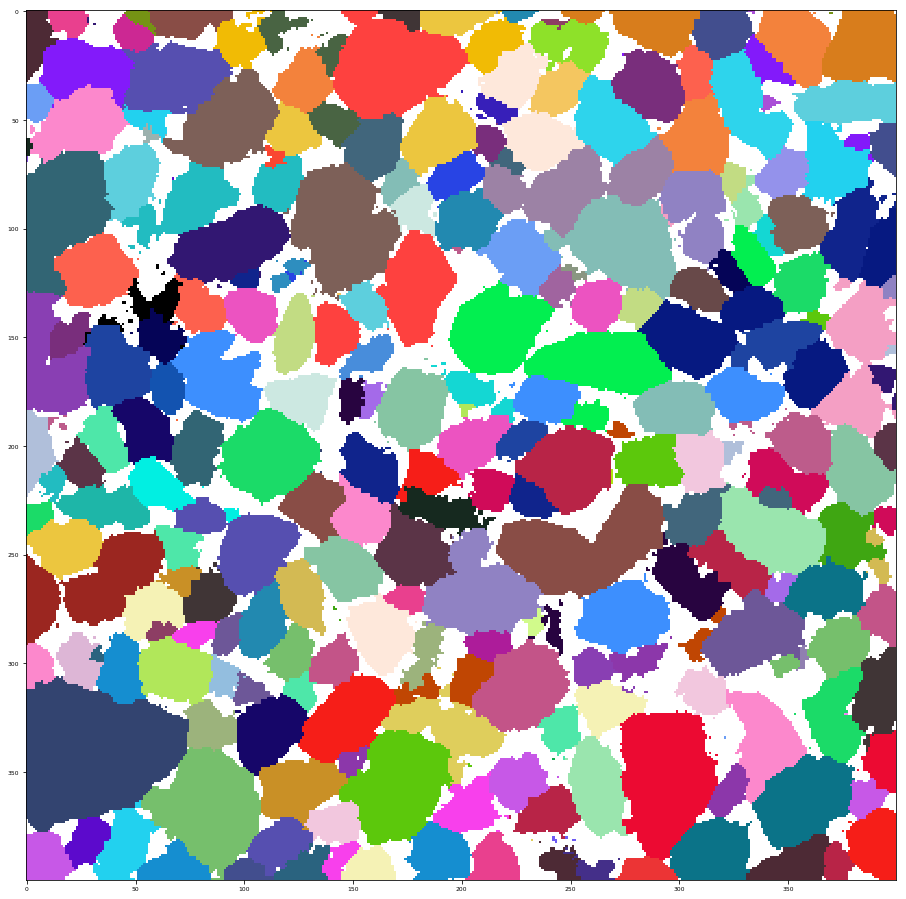

In [124]:
plt.figure(figsize=(16,16))
plt.imshow(G_water[80], cmap=spam.label.randomCmap)

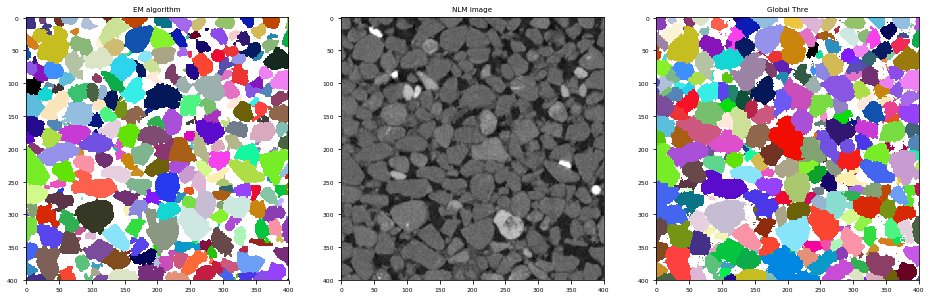

In [98]:
idx = 1
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(EM_water[i], cmap=spam.label.randomCmap)
plt.title('EM algorithm')
plt.subplot(1,3,2)
plt.imshow(nlm_img[i], cmap='gray')
plt.title('NLM image')
plt.subplot(1,3,3)
plt.imshow(G_water[i], cmap=spam.label.randomCmap)
plt.title('Global Thre')
plt.show()

In [112]:
save_path = '/home/hasitha/Desktop/packed_img/'
tif.imsave(save_path+'gray_EM_binaries.tif', EM_binaries_bk)

In [100]:
save_path = '/home/hasitha/Desktop/packed_img/'
tif.imsave(save_path+'lab_EM_water.tif', EM_water)

In [101]:
save_path = '/home/hasitha/Desktop/packed_img/'
tif.imsave(save_path+'gray_G_binaries.tif', global_binaries)

In [102]:
save_path = '/home/hasitha/Desktop/packed_img/'
tif.imsave(save_path+'lab_G_water.tif', G_water)

In [103]:
type(EM_binaries[0,0,0])

numpy.float64

In [109]:
EM_binaries_bk = EM_binaries.astype(np.bool)

In [110]:
EM_binaries_bk.shape

(400, 400, 400)

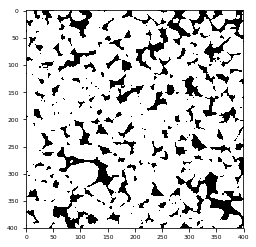

In [111]:
plt.imshow(EM_binaries_bk[20], plt.cm.gray)

require 46 steps to finish
[98.768 41.755]


Text(0.5, 1.0, 'weighted Expectation-Maximization Algorithm')

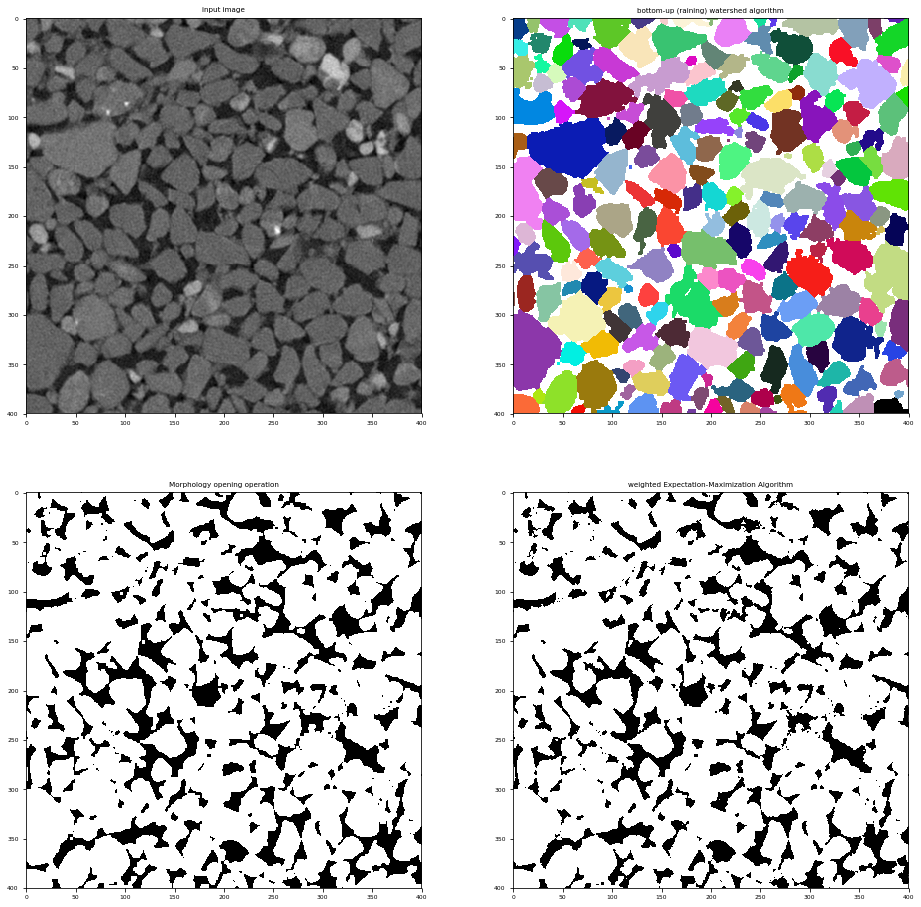

In [83]:
idx = 92
data = nlm_img[idx].reshape(-1,1)
EM_labels, log_likelihoods, EM_parms = EM_calc(num_dims=1,num_samples=len(data),num_clusters=2,x=data/16)
print(EM_parms['mu'].flatten())
"""
while(EM_parms['mu'].min()>60):
    EM_labels, log_likelihoods, EM_parms = EM_calc(num_dims=1,num_samples=len(data),num_clusters=2,x=data/16)
"""
EM_binary = EM_labels != np.argmin(EM_parms['mu'])
kernel = np.ones((3,3))
binary3 = cv2.morphologyEx(np.float32(EM_binary.reshape(400,400)), cv2.MORPH_OPEN, kernel,iterations=1)
#binary3 = cv2.morphologyEx(np.float32(full_img[idx]>90), cv2.MORPH_OPEN, kernel,iterations=2)
water = spam.label.watershed(binary3)
plt.figure(figsize=(16,16))
plt.subplot(2,2,1)
plt.imshow(full_img[idx], cmap='gray')
plt.title('input image')
plt.subplot(2,2,2)
plt.imshow(water,cmap=spam.label.randomCmap)
plt.title('bottom-up (raining) watershed algorithm')
plt.subplot(2,2,3)
plt.imshow(binary3,cmap='gray')
plt.title('Morphology opening operation')
plt.subplot(2,2,4)
plt.imshow(EM_binary.reshape(400,400), cmap='gray')
plt.title('weighted Expectation-Maximization Algorithm')
#plt.savefig('{}.png'.format(idx), dpi=500, bbox_inches='tight')


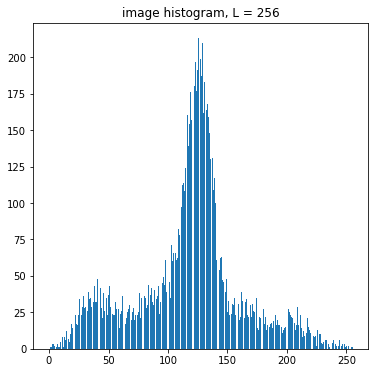

In [397]:
hist = image_histogram(full_img[idx], 256, True)

In [722]:
a = np.arange(25).reshape(5,5)
b = np.arange(5)
c = np.arange(5)

In [496]:
np.einsum('ij->i', a)

array([ 10,  35,  60,  85, 110])

In [542]:
a

array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14],
       [15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24]])

In [723]:
c

array([0, 1, 2, 3, 4])

In [724]:
np.einsum('i,ij->j', c, a)

array([150, 160, 170, 180, 190])

In [725]:
5+20+45+80

150

In [743]:
c*c

array([ 0,  1,  4,  9, 16])

In [759]:
d = np.array([12,4,2.5,6,8.88])

In [760]:
d.shape

(5,)

In [749]:
c.shape

(5,)

In [752]:
d

array([[12.  ],
       [ 4.  ],
       [ 2.5 ],
       [ 6.  ],
       [ 8.88]])

In [789]:
(c*d.T)

array([ 0.  ,  4.  ,  5.  , 18.  , 35.52])

In [761]:
c*d

array([ 0.  ,  4.  ,  5.  , 18.  , 35.52])

In [787]:
d.T

array([12.  ,  4.  ,  2.5 ,  6.  ,  8.88])

In [788]:
(d.T).shape

(5,)